In [1]:
! pip install torch transformers datasets peft accelerate evaluate scikit-learn bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 MB 10.7 MB/s eta 0:00:00


In [5]:
import torch
import numpy as np
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForMultipleChoice,
    TrainingArguments,
    Trainer,
)
from peft import LoraConfig, get_peft_model
from sklearn.metrics import accuracy_score, f1_score

# CONFIGURATION

In [6]:
MODEL_NAME = "roberta-base"
MAX_LENGTH = 128
BATCH_SIZE = 8
EPOCHS = 2
LEARNING_RATE = 3e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print("Using device:", DEVICE)

Using device: cuda


# LOADING DATASET

In [7]:
dataset = load_dataset("lex_glue", "case_hold")

dataset["train"] = dataset["train"].select(range(8000))
dataset["validation"] = dataset["validation"].select(range(1500))
dataset["test"] = dataset["test"].select(range(1500))

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## PREPROCESS FUNCTION

In [8]:
def preprocess_function(examples):
    first_sentences = []
    second_sentences = []

    for context, endings in zip(examples["context"], examples["endings"]):
        for ending in endings:
            first_sentences.append(context)
            second_sentences.append(ending)

    tokenized = tokenizer(
        first_sentences,
        second_sentences,
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH,
    )

    tokenized = {k: [v[i:i+5] for i in range(0, len(v), 5)] for k, v in tokenized.items()}
    tokenized["labels"] = examples["label"]

    return tokenized

encoded_dataset = dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=dataset["train"].column_names,
)

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

## METRICS

In [9]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    return {
        "accuracy": accuracy_score(labels, preds),
        "macro_f1": f1_score(labels, preds, average="macro"),
    }

#  BASELINE

In [10]:
print("\n========== BASELINE ==========")

baseline_model = AutoModelForMultipleChoice.from_pretrained(MODEL_NAME).to(DEVICE)

baseline_trainer = Trainer(
    model=baseline_model,
    args=TrainingArguments(
        output_dir="./baseline",
        per_device_eval_batch_size=BATCH_SIZE,
        report_to="none",
    ),
    eval_dataset=encoded_dataset["validation"],
    compute_metrics=compute_metrics,
)

baseline_results = baseline_trainer.evaluate()
print("Baseline Results:", baseline_results)


========== BASELINE ==========


Some weights of RobertaForMultipleChoice were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Baseline Results: {'eval_loss': 1.6096161603927612, 'eval_accuracy': 0.19, 'eval_macro_f1': 0.18944395183000556, 'eval_runtime': 50.8114, 'eval_samples_per_second': 29.521, 'eval_steps_per_second': 3.7}


# FULL FINE-TUNING

In [11]:
print("\n========== FULL FINE-TUNING ==========")

fft_model = AutoModelForMultipleChoice.from_pretrained(MODEL_NAME).to(DEVICE)

fft_trainer = Trainer(
    model=fft_model,
    args=TrainingArguments(
        output_dir="./fft",
        evaluation_strategy="epoch",
        save_strategy="no",
        learning_rate=LEARNING_RATE,
        warmup_ratio=0.1,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        num_train_epochs=EPOCHS,
        weight_decay=0.01,
        report_to="none",
    ),
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    compute_metrics=compute_metrics,
)

fft_trainer.train()

fft_results = fft_trainer.evaluate(encoded_dataset["test"])
print("Full Fine-Tuning Results:", fft_results)


========== FULL FINE-TUNING ==========


/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForMultipleChoice were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,1.090400,1.026176,0.598667,0.597993
2,0.849200,1.040632,0.605333,0.604292


Full Fine-Tuning Results: {'eval_loss': 1.1293021440505981, 'eval_accuracy': 0.5886666666666667, 'eval_macro_f1': 0.5885573486832892, 'eval_runtime': 55.5006, 'eval_samples_per_second': 27.027, 'eval_steps_per_second': 3.387, 'epoch': 2.0}


# LoRA FINE-TUNING

In [12]:
print("\n========== LoRA FINE-TUNING ==========")

lora_model = AutoModelForMultipleChoice.from_pretrained(MODEL_NAME)

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["query", "value"],
    lora_dropout=0.05,
    bias="none",
    task_type="SEQ_CLS",
)

lora_model = get_peft_model(lora_model, lora_config)
lora_model.to(DEVICE)
lora_model.print_trainable_parameters()

lora_trainer = Trainer(
    model=lora_model,
    args=TrainingArguments(
        output_dir="./lora",
        evaluation_strategy="epoch",
        save_strategy="no",
        learning_rate=5e-5,
        warmup_ratio=0.1,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        num_train_epochs=EPOCHS,
        weight_decay=0.01,
        report_to="none",
    ),
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    compute_metrics=compute_metrics,
)

lora_trainer.train()

lora_results = lora_trainer.evaluate(encoded_dataset["test"])
print("LoRA Results:", lora_results)


========== LoRA FINE-TUNING ==========


/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForMultipleChoice were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 590,593 || all params: 125,236,994 || trainable%: 0.4715803063749678


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,1.407200,1.183257,0.544667,0.543707
2,1.197100,1.115514,0.554000,0.553101


LoRA Results: {'eval_loss': 1.1458972692489624, 'eval_accuracy': 0.556, 'eval_macro_f1': 0.5558386795093961, 'eval_runtime': 56.1213, 'eval_samples_per_second': 26.728, 'eval_steps_per_second': 3.35, 'epoch': 2.0}


# FINAL COMPARISON

In [14]:
import pandas as pd

comparison_table = pd.DataFrame({
    "Model": ["Baseline", "Full Fine-Tuning", "LoRA"],
    "Accuracy": [
        baseline_results["eval_accuracy"],
        fft_results["eval_accuracy"],
        lora_results["eval_accuracy"],
    ],
    "Macro F1": [
        baseline_results["eval_macro_f1"],
        fft_results["eval_macro_f1"],
        lora_results["eval_macro_f1"],
    ],
    "Loss": [
        baseline_results["eval_loss"],
        fft_results["eval_loss"],
        lora_results["eval_loss"],
    ]
})

print("\n========== FINAL COMPARISON ==========")
display(comparison_table)


========== FINAL COMPARISON ==========


,Model,Accuracy,Macro F1,Loss
0,Baseline,0.190000,0.189444,1.609616
1,Full Fine-Tuning,0.588667,0.588557,1.129302
2,LoRA,0.556000,0.555839,1.145897


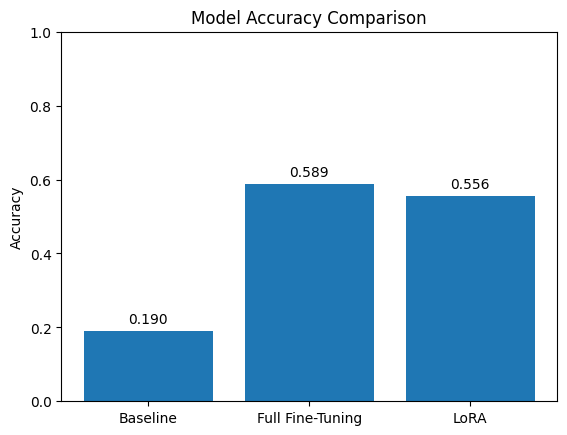

In [15]:
import matplotlib.pyplot as plt

models = ["Baseline", "Full Fine-Tuning", "LoRA"]
accuracies = [
    baseline_results["eval_accuracy"],
    fft_results["eval_accuracy"],
    lora_results["eval_accuracy"],
]

plt.figure()
bars = plt.bar(models, accuracies)

plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)

# Add value labels
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f"{v:.3f}", ha="center")

plt.show()